У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

### Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

In [3]:
!pip install -U imbalanced-learn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,  MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from imblearn.combine import SMOTETomek
from sklearn.multiclass import OneVsRestClassifier

**Завдання 1.** Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [6]:
start_df = pd.read_csv('customer_segmentation_train.csv') # завантажуємо набір даних
start_df.head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [7]:
start_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [8]:
#ID має числовий формат, а це є не логічно і не оптимально з точки зору розміру даних. Змінимо тип даних в колонці на str
start_df['ID'] = start_df['ID'].astype("str")

In [9]:
#виводимо список категоріальних колонок
cat_col = start_df.select_dtypes(include = "object").columns

#виводимо список числових колонок
num_col = start_df.select_dtypes(include="number").columns

In [10]:
#аналізуємо відсутні значення у числових колонках
num_df = start_df[num_col]
null_count = num_df.isnull().sum()
null_percentage = round((num_df.isnull().sum()/num_df.shape[0])*100, 2)

#рахуємо середнє, моду, медіану
mean_amt_req = num_df.mean().round(2)
mode_amt_req = num_df.mode()
median_amt_req = num_df.median()

#записуємо датафрейм, додаємо стовпці з розрахунками
num_df = pd.DataFrame({'object' : num_df.columns,
                       'null_count':null_count, 
                       'null_percentage':null_percentage,
                       'mean' : mean_amt_req,
                       'median':median_amt_req}).reset_index()

num_df = num_df.merge(mode_amt_req.transpose().reset_index()).drop('index', axis=1)
new_names = {0: 'mode'}
num_df = num_df.rename(columns=new_names)

num_df.sort_values(by = 'null_percentage', ascending = False)

,object,null_count,null_percentage,mean,median,mode
1,Work_Experience,829,10.28,2.64,1.0,1.0
2,Family_Size,335,4.15,2.85,3.0,2.0
0,Age,0,0.00,43.47,40.0,35.0


З результатів розрахунку бачимо, що маємо пропущені значення у двох з трьох числових змінних:
- `Work_Experience` 10,28%. По даному показнику також спостерігаємо наявність викидів (середнє значення більше моди і медіани)
- `Family_Size`4,15%.

  Подивимось як розподілені дані:

Text(0.5, 0, 'Family_Size')

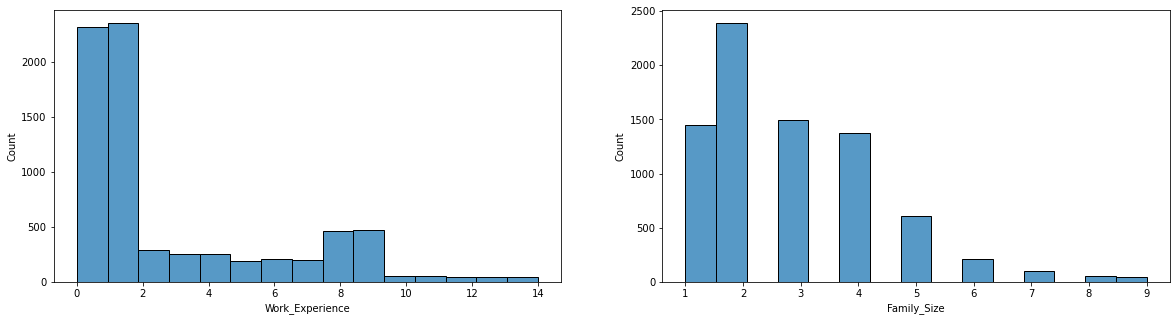

In [12]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.histplot(start_df['Work_Experience'], bins = 15)
plt.xlabel('Work_Experience')

plt.subplot(1,2,2)
sns.histplot(start_df['Family_Size'], bins = 15)
plt.xlabel('Family_Size')

З отриманих графіків розподілення можемо зробити висновок, що:
- `Work_Experience` має викиди і довгий правий хвіст. Для даного стовпця будемо заповнювати відсутні значення медіаною
- `Family_Size` теж має викиди, але хвіст з права не такий довгий. Для даного стовпця пропущенні значення будем заповнювати також медіаною

In [14]:
start_df['Work_Experience'].fillna(start_df['Work_Experience'].median(), inplace=True)
start_df['Family_Size'].fillna(start_df['Family_Size'].median(), inplace=True)

In [15]:
#аналізуємо відсутні значення у категоріальних колонках
unique = start_df[cat_col].nunique()
cat_df = start_df[cat_col]

null_count = cat_df.isnull().sum()
null_percentage = round((cat_df.isnull().sum()/cat_df.shape[0])*100, 2)

null_df = pd.DataFrame({'column_name' : cat_df.columns,'null_count' : null_count,'null_percentage': null_percentage})
null_df.reset_index(drop = True, inplace = True)

#записуємо датафрейм, додаємо стовпці з розрахунками
null_df = pd.DataFrame({'object' : cat_df.columns,
                       'null_count':null_count, 
                       'null_percentage':null_percentage,
                       'unique' :unique}).reset_index()

null_df = null_df.reset_index().drop('index', axis=1)
null_df.sort_values(by = 'null_percentage', ascending = False)

,level_0,object,null_count,null_percentage,unique
2,2,Ever_Married,140,1.74,2
4,4,Profession,124,1.54,9
3,3,Graduated,78,0.97,2
6,6,Var_1,76,0.94,7
0,0,ID,0,0.00,8068
1,1,Gender,0,0.00,2
5,5,Spending_Score,0,0.00,3
7,7,Segmentation,0,0.00,4


З отриманих даних бачимо, що відсутні значення є в 4-х категоріальних колонках:
- `Ever_Married` 1,74% відсутніх значень, колонка бінарна. Відсутні значення заповнимо значенням, що зустрічається частіше
- `Profession` 1,54% відсутніх значень, колонка містить 9 унікальних значень. Відсутні будемо заповнювати як "unknown"
- `Graduated` 0,97% відсутніх значень, колонка бінарна. Відсутні значення будемо видаляти
- `Var_1` 0,94% відсутніх значень, колонка містить 7 унікальних значень. Відсутні значення будемо видаляти

In [17]:
start_df['Ever_Married'].fillna(start_df['Ever_Married'].mode()[0], inplace=True)
start_df['Profession'].fillna(value = 'Unknown', inplace = True)
start_df = start_df.dropna(subset=['Graduated'])
start_df = start_df.dropna(subset=['Var_1'])

start_df

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,Male,No,22,No,Unknown,0.0,Low,7.0,Cat_1,D
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,Cat_4,D
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Cat_6,D
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6,B


Тепер ми маємо готовий до подальшої роботи датасет

In [19]:
start_df_c = start_df.copy()
#кодуємо бінарні категоріальні дані
Gender_codes = {'Female': 0, 'Male': 1}
start_df_c['Gender_codes'] = start_df_c.Gender.map(Gender_codes)

Graduated_codes = {'No': 0, 'Yes': 1}
start_df_c['Graduated_codes'] = start_df_c.Graduated.map(Graduated_codes)

Ever_Married_codes = {'No': 0, 'Yes': 1}
start_df_c['Ever_Married_codes'] = start_df_c.Ever_Married.map(Ever_Married_codes)

#кодуємо категоріальні дані, що мають відношення порядку
ordenc = OrdinalEncoder(categories=[['Low', 'Average', 'High']]) # визначаємо порядок категорій

ordenc.fit(start_df_c[['Spending_Score']])
start_df_c['Spending_Score_Codes'] = ordenc.transform(start_df_c[['Spending_Score']])

#кодуємо інші категоріальні колонки
le = LabelEncoder()

profession_s = start_df_c['Profession']
start_df_c['Profession_Codes'] = le.fit_transform(profession_s)

Var_1_s = start_df_c['Var_1']
start_df_c['Var_1_Codes'] = le.fit_transform(Var_1_s)

Segmentation_s = start_df_c['Segmentation']
start_df_c['Segmentation_Codes'] = le.fit_transform(Segmentation_s)

start_df_c.head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Gender_codes,Graduated_codes,Ever_Married_codes,Spending_Score_Codes,Profession_Codes,Var_1_Codes,Segmentation_Codes
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D,1,0,0,0.0,5,3,3
1,462643,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,A,0,1,1,1.0,2,3,0
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B,0,1,1,0.0,2,5,1
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B,1,1,1,2.0,7,5,1
4,462669,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,A,0,1,1,2.0,3,5,0


In [20]:
#масштабуємо числові колонки
scaler = MinMaxScaler()

scaler.fit(start_df_c[num_col])
start_df_c[num_col] = scaler.transform(start_df_c[num_col])

In [21]:
#Видаляємо оригінали закодованих колонок і результати записуємо в новий датасет
columns_to_drop = ['ID','Segmentation', 'Var_1', 'Profession', 'Spending_Score', 'Ever_Married', 'Graduated', 'Gender']

cod_df = start_df_c.drop(columns_to_drop, axis=1)

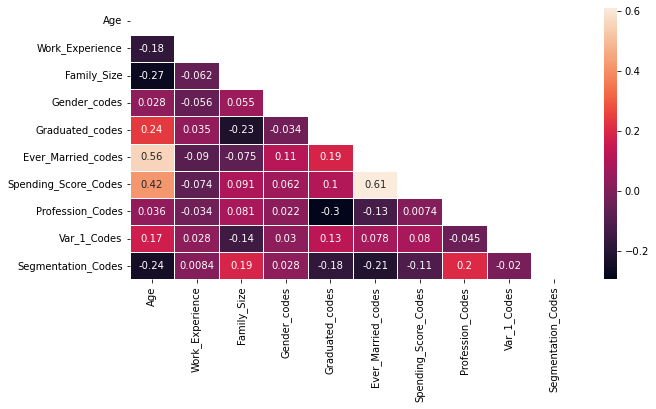

In [22]:
# будуємо матрицю кореляції
plt.figure(figsize=(10, 5))
matrix = np.triu(cod_df.corr())
sns.heatmap(cod_df.corr(), annot=True, linewidth=.8, mask=matrix, cmap="rocket");

In [23]:
#виводимо показники кореляції по всім даним
df_cor=cod_df.corr()

df_cor2=pd.DataFrame(
    {
        "Параметр":df_cor.index,
        "Segmentation":df_cor['Segmentation_Codes']
    }
).groupby('Параметр').first()

df_cor3=df_cor2.loc[df_cor2['Segmentation'] < 1]

df_cor4=df_cor3.nlargest(9, 'Segmentation')

df_cor4

,Segmentation
Параметр,
Profession_Codes,0.203589
Family_Size,0.192452
Gender_codes,0.028382
Work_Experience,0.008379
Var_1_Codes,-0.019501
Spending_Score_Codes,-0.108410
Graduated_codes,-0.179065
Ever_Married_codes,-0.214171
Age,-0.244674


З отриманих результатів кореляції бачимо достатньо низький рівень кореляції даних і зворотні кореляціі.
Для подальшої роботи зробимо вибірку кращих за кореляцією даних

In [25]:
columns_to_drop = ['Gender_codes','Work_Experience', 'Var_1_Codes']

cod_df = cod_df.drop(columns_to_drop, axis=1)

cod_df.head(5)

,Age,Family_Size,Graduated_codes,Ever_Married_codes,Spending_Score_Codes,Profession_Codes,Segmentation_Codes
0,0.056338,0.375,0,0,0.0,5,3
1,0.281690,0.250,1,1,1.0,2,0
2,0.690141,0.000,1,1,0.0,2,1
3,0.690141,0.125,1,1,2.0,7,1
4,0.309859,0.625,1,1,2.0,3,0


Accuracy on Train dataset: 0.49


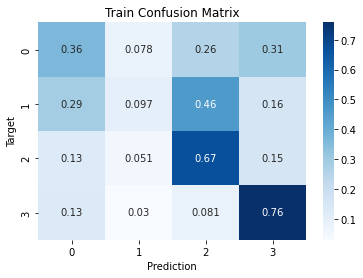

Accuracy on Test dataset: 0.49


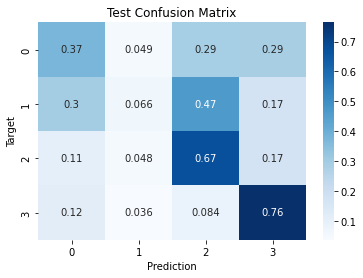

In [26]:
#розбиваємо дані на трейн і тест
train_df, test_df = train_test_split(cod_df, test_size=0.2, random_state=42)

# Створюємо трен. і тест. набори
input_cols = list(train_df.columns)[:-1]
target_col = 'Segmentation_Codes'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
test_inputs, test_targets = test_df[input_cols], test_df[target_col]

#тренуємо модель
model = LogisticRegression(solver='liblinear')
model.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model, inputs, targets, name=''):
    preds = model.predict(inputs)
    accuracy = accuracy_score(targets, preds)
    print(f"Accuracy on {name} dataset: {accuracy:.2f}")
    #roc_auc = roc_auc_score(targets, preds, multi_class='ovr')
    #print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model, train_inputs, train_targets, 'Train')
test_preds = predict_and_plot(model, test_inputs, test_targets, 'Test')

З отриманих результатів бачимо, що модель достатньо погано працює на даних. Що трейнова, що тестова вибірки показуть accuracy score 0.49.

На матриці бачимо, що `Segmentation` визначилися не рівномірно: найкращий результат у 3-го, найгірший у 1-го

Необхідно далі працювати над поліпшенням моделі

**Завдання 2. Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

In [29]:
#створюємо трейнову і тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(start_df.drop('Segmentation', axis = 1).select_dtypes(include="number"),
                                                    start_df['Segmentation'],
                                                    test_size = 0.4,
                                                    random_state = 42,
                                                    stratify=start_df['Segmentation']
                                                    )

y_train

4727    D
1979    B
7066    A
4397    C
2491    D
       ..
7102    A
7063    A
5702    A
3549    D
6591    B
Name: Segmentation, Length: 4748, dtype: object

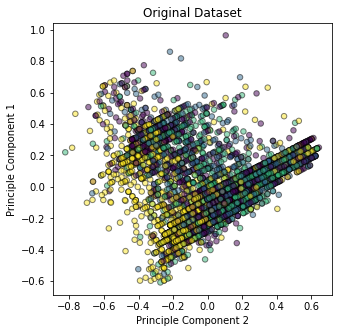

In [30]:
#масштабуємо числові дані
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#кодуємо цільову змінну
Segmentation_tr = y_train
y_train = le.fit_transform(Segmentation_tr)

Segmentation_te = y_test
y_test = le.fit_transform(Segmentation_te)

pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

def plot_data(X, y, ax, title):
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, s = 30, edgecolor=(0,0,0,0.5))
    ax.set_ylabel('Principle Component 1')
    ax.set_xlabel('Principle Component 2')
    if title is not None:
        ax.set_title(title)

fig,ax = plt.subplots(figsize=(5, 5))
plot_data(X_train_pca, y_train, ax, title='Original Dataset')

In [31]:
#використовуємо SMOTE
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train)

clf_smote = SVC(kernel='linear',probability=True)
clf_smote.fit(X_train_smote, y_train_smote)

SVC(kernel='linear', probability=True)

In [32]:
pd.Series(y_train_smote).value_counts()

3    1334
1    1334
0    1334
2    1334
dtype: int64

In [33]:
pd.Series(y_train).value_counts()

3    1334
2    1160
0    1158
1    1096
dtype: int64

Бачимо, що при застосуванні `smote` кіл-ть екзеплярів вирівнялась

In [35]:
#використовуємо SMOTETomek
smotetomek = SMOTETomek(random_state=0)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train_pca, y_train)

clf_smotetomek = SVC(kernel='linear',probability=True)
clf_smotetomek.fit(X_train_smotetomek, y_train_smotetomek)


SVC(kernel='linear', probability=True)

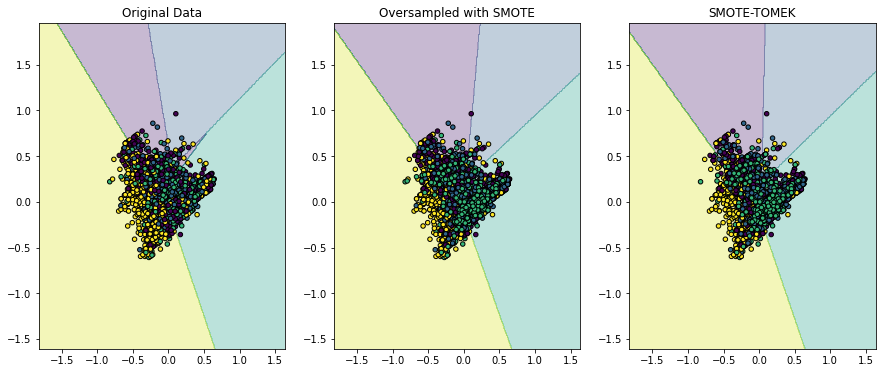

In [36]:
clf = SVC(kernel='linear',probability=True)
clf.fit(X_train_pca, y_train)

def plot_decision_boundaries(X, y, clf, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o', s=20)
    ax.set_title(title)
    return scatter

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
plot_decision_boundaries(X_train_pca, y_train, clf, axes[0], "Original Data")
plot_decision_boundaries(X_train_smote, y_train_smote, clf_smote, axes[1], "Oversampled with SMOTE");
plot_decision_boundaries(X_train_smotetomek, y_train_smotetomek, clf_smotetomek, axes[2], "SMOTE-TOMEK");

**Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?

In [38]:
# Логістична регресія зі стратегією one-vs-rest (OvR) на оригінальних даних
log_reg = LogisticRegression(solver='liblinear')
ovr_model = OneVsRestClassifier(log_reg)
orig = ovr_model.fit(X_train, y_train)
ovr_predictions_orig = orig.predict(X_test)

# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_test, ovr_predictions_orig))

              precision    recall  f1-score   support

           0       0.33      0.28      0.30       771
           1       0.22      0.01      0.02       731
           2       0.37      0.48      0.42       774
           3       0.46      0.76      0.58       890

    accuracy                           0.40      3166
   macro avg       0.35      0.38      0.33      3166
weighted avg       0.35      0.40      0.34      3166



In [41]:
#збалансовані з SMOTE
SMOTE_ = ovr_model.fit(X_train_smote, y_train_smote)
ovr_predictions_SMOTE = SMOTE_.predict(X_test_pca)

# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_test, ovr_predictions_SMOTE))

              precision    recall  f1-score   support

           0       0.29      0.17      0.21       771
           1       0.27      0.07      0.11       731
           2       0.34      0.53      0.41       774
           3       0.48      0.71      0.58       890

    accuracy                           0.39      3166
   macro avg       0.35      0.37      0.33      3166
weighted avg       0.35      0.39      0.34      3166



In [42]:
#збалансовані з Smote-Tomek
SM_T = ovr_model.fit(X_train_smotetomek, y_train_smotetomek)
ovr_predictions_SM_T = SM_T.predict(X_test_pca)

# Обчислимо метрики precision та recall для кожного класу
print(classification_report(y_test, ovr_predictions_SM_T))

              precision    recall  f1-score   support

           0       0.30      0.17      0.22       771
           1       0.26      0.05      0.09       731
           2       0.33      0.54      0.41       774
           3       0.48      0.71      0.57       890

    accuracy                           0.39      3166
   macro avg       0.34      0.37      0.32      3166
weighted avg       0.35      0.39      0.34      3166



**Висновок:**
На мою думку для оцінки даних моделей краще використовувати `precision` оскількі він демонструє точність передбачення класу.

Аналізуючи `precision` трьох моделей бачимо, що суттєвої різниці немає. Це може бути пов"язано з тим, що оригінальні дані дуже щільні і накладаються один на один. Це не дає змоги чітко визначити кордони і, відповідно, розмежувати класи.